### Questions

- What does label look like if no raccoons?
- How is loss calculated for bounding box?

### Thoughts

- if we resize, we have to rescale bounding box also

In [21]:
import cv2
import time
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [38]:
data_path = './Data/Racoon Images/images'
df = pd.read_csv('./Data/train_labels_.csv')

In [3]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [4]:
# Sample Image
path = data_path + '/' + df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(194, 259, 3)

In [5]:
# Bounding box for sample image
x0 = df.iloc[0]['xmin']
y0 = df.iloc[0]['ymin']
x1 = df.iloc[0]['xmax']
y1 = df.iloc[0]['ymax']
(x0,y0), (x1,y1)

((95, 60), (167, 118))

In [6]:
def display_imgbb(img, xmin, ymin, xmax, ymax):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin), (xmax - xmin) , (ymax - ymin) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

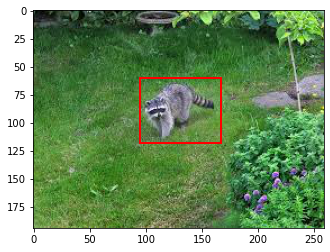

In [7]:
display_imgbb(img,x0,y0,x1,y1)

In [8]:
# smallest w,h
df['width'].min(), df['height'].min()

(178, 154)

In [39]:
# Rescale bounding box in preparation for rescaling images
image_size = 128
df['xmin_rs'] = df['xmin']*image_size/df['width']
df['xmax_rs'] = df['xmax']*image_size/df['width']
df['ymin_rs'] = df['ymin']*image_size/df['height']
df['ymax_rs'] = df['ymax']*image_size/df['height']

In [108]:
# Images with >1 raccoon, remove to simplify model
new = pd.DataFrame(df.filename.value_counts() > 1)
new = new.reset_index()
new = new[new['filename'] == True]
for_removal = list(new['index'].values)
len(for_removal)

12

In [114]:
# Images with 1 raccoon only
df = df[~df['filename'].isin(for_removal)]
len(df)

148

In [31]:
# !mkdir Data/Racoon\ Images/images_rs

In [39]:
# Resize images before training
# def resize_img(path, newpath, size):
#     img = cv2.imread(path)
    
#     start = time.time()
#     img = cv2.resize(img, size)
#     end = time.time()
    
#     cv2.imwrite(newpath, img)
#     return end - start

# # resize all of the images
# total_time_resize = 0.0
# for idx in tqdm(range(len(df))):
#     row = df.iloc[idx]
#     fname = row['filename']
#     path = data_path + '/' + row['filename']
#     newpath = './Data/Racoon Images/images_rs'+'/'+fname
    
#     total_time_resize += resize_img(path, newpath, (image_size, image_size))
# total_time_resize

  0%|          | 0/173 [00:00<?, ?it/s]

In [116]:
# Train/valid split
valid = df.sample(frac=.2)
train = df.drop(valid.index)
len(train),len(valid)

(118, 30)

In [129]:
class RaccoonDataset(Dataset):
    def __init__(self, df, root):
        # Dataframe with bounding boxes
        self.df = df
        self.root = root
        
    def __len__(self):
        return len(self.df) # this only works if 1:1 image:label
    
    def __getitem__(self, idx):
        row = df.iloc[idx]
        
        # Create image array
        fname = row['filename']
        img_path = self.root + '/' + fname
        img = cv2.imread(path)
        
        # Get bounding box label
        xmin, ymin = tuple(list(row[['xmin_rs','ymin_rs']].values))
        xmax, ymax = tuple(list(row[['xmax_rs','ymax_rs']].values))
        label = ((xmin,ymin), (xmax,ymax))
        
        return img, label

In [130]:
root = '/Users/elysecs/Documents/GitHub/DeepLearning/Object_Detection_DL/Data/Racoon Images/images_rs'
train_ds = RaccoonDataset(train, root)
valid_ds = RaccoonDataset(valid, root)

In [131]:
next(iter(train_ds))

(None,
 ((46.94980694980695, 39.58762886597938),
  (82.53281853281854, 77.85567010309278)))

In [122]:
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=False)

In [128]:
x = cv2.imread('/Users/elysecs/Documents/GitHub/DeepLearning/Object_Detection_DL/Data/Racoon Images/images_rs/raccoon-17.jpg')
x.shape

(128, 128, 3)